In [1]:
import sys, importlib
# "../" to go back one director
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
import os
# import torch.nn as nn
# from Modules.Utils.Imports import *
# from Modules.Utils.JTNPDESolver import *
# from Modules.Utils.Gradient import Gradient
# from Modules.Utils.ModelWrapper import ModelWrapper
# from Modules.Models.BuildSurfaceFitter import *
# from torch.autograd import Variable
# import Modules.Utils.PDESolver as PDESolver
# import DataFormatter as DF

import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
import scipy.io
from scipy import integrate, interpolate
from scipy.sparse import spdiags
from scipy import sparse
import bisect
import matplotlib.colors as colors
import matplotlib.cm as cm

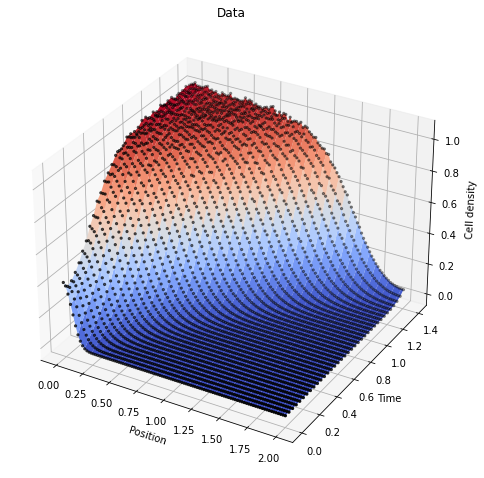

In [2]:
from Projects.Scripts.Data_Processor import *
path = os.getcwd()+'/NPY_Data/data_wider_3P_E2.npy'
save_path = 'Figures/Data_N01_3P_E2.pdf'

inputs, outputs, X, T, U, shape, data = ProcessData(path, 
                                                    t_end_idx=35, 
                                                    load_noisy=True, 
                                                    plot=True, 
                                                    save_path=save_path)

In [3]:
x = np.unique(X)
t = np.unique(T)

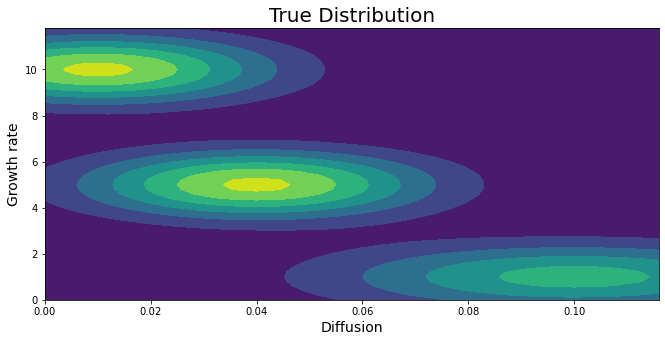

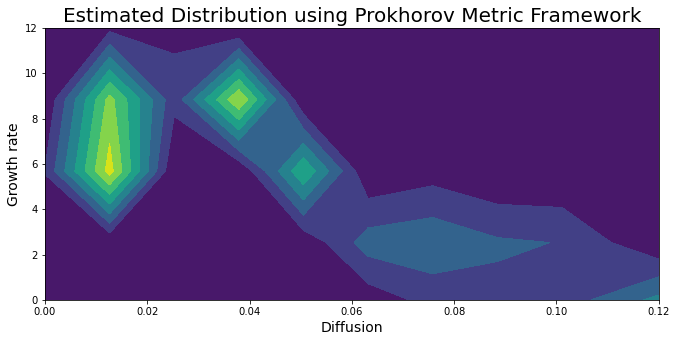

In [4]:
from Projects.Scripts.Plotters import *

max_D_nodes = 20
max_rho_nodes = 20
max_K_nodes = 1

D_min = 0.0
D_max = 0.12
rho_min = 0.0
rho_max = 12.0
K_min = 1.0
K_max = 1.0

weights_mesh = data['pdf_mesh']

fig1, ax1 = Plot_PDF(np.reshape(data['D_params'],weights_mesh.shape), 
                   np.reshape(data['rho_params'],weights_mesh.shape),
                   weights_mesh = data['pdf_mesh'],
                   x_label='Diffusion', 
                   y_label='Growth rate',
                   title='True Distribution',
                   save_path='Figures/TrueMesh_N01_3P_E2.pdf')

numX = len(x)
numT = len(t)

#### Interpolation
load_file = 'PMF_Results_Interp_3P_E2/best_PMF.npy'     
best_results_Interp = np.load(load_file, allow_pickle=True).item()
        
# Interp_best_numDnode = best_numDnode
# Interp_best_numKnode = best_numKnode
# Interp_weights = best_weights
Interp_RSS = best_results_Interp['best_RSS']

D_vec = np.linspace(D_min, D_max, max_D_nodes)
rho_vec = np.linspace(rho_min, rho_max, max_rho_nodes)
K_vec = np.linspace(K_min, K_max, max_K_nodes)

num_D_node = best_results_Interp['best_numDnode']
num_rho_node = best_results_Interp['best_numRhonode']
weights = best_results_Interp['best_weights']
weights = weights.reshape((best_results_Interp['best_numDnode'],best_results_Interp['best_numRhonode']))

D_vec_idx = np.floor(np.linspace(0,max_D_nodes-1, num_D_node))
rho_vec_idx = np.floor(np.linspace(0,max_rho_nodes-1, num_rho_node))
D_vec_idx = D_vec_idx.astype(int)
rho_vec_idx = rho_vec_idx.astype(int)

D_vec = D_vec[D_vec_idx]
rho_vec = rho_vec[rho_vec_idx]

D_mesh, rho_mesh = np.meshgrid(D_vec, rho_vec, indexing='ij')

fig2, ax2 = Plot_PDF(D_mesh, 
                   rho_mesh,
                   weights_mesh = weights,
                   x_label='Diffusion', 
                   y_label='Growth rate',
                   title='Estimated Distribution using Prokhorov Metric Framework',
                   save_path='Figures/PMFMesh_N01_3P_E2.pdf')

In [5]:
D_mesh, rho_mesh = np.meshgrid(D_vec, rho_vec, indexing='ij')
D_mesh = D_mesh.reshape((-1, 1))
rho_mesh = rho_mesh.reshape((-1, 1))
weights = weights.reshape((-1, 1))

PMF_params = np.concatenate((D_mesh, rho_mesh, weights), axis=1)

PMF_params = np.delete(PMF_params, (weights.T == 0)[0], axis=0)
D_mesh = np.delete(D_mesh, (weights.T == 0)[0], axis=0)
rho_mesh = np.delete(rho_mesh, (weights.T == 0)[0], axis=0)
weights = np.delete(weights, (weights.T == 0)[0], axis=0)
PMF_params = np.concatenate((D_mesh, rho_mesh, weights), axis=0)

In [6]:
from Projects.Scripts.PDEResults_Processor import *
num_run = 20
PDE_folder = os.getcwd()+'/PDE_Fitting_Results_3P_E2'

num_PDE = 2
optimized_params_2P, best_error_2P, total_2P_time = Process_PDEResults(PDE_folder, num_PDE, num_run)

num_PDE = 4
optimized_params_4P, best_error_4P, total_4P_time = Process_PDEResults(PDE_folder, num_PDE, num_run)

num_PDE = 6
optimized_params_6P, best_error_6P, total_6P_time = Process_PDEResults(PDE_folder, num_PDE, num_run)

In [7]:
def PDE_RHS(t,u,x,params,K,num_PDE):
    
    ''' returns a RHS of the form:
        q[0]*(g(u)u_x)_x + q[1]*f(u)
        where f(u) is a two-phase model
        
        and q[2] is carrying capacity
    '''
    
    #
    n = len(x)
    e = np.ones((n,))
    A = spdiags([e,-2*e,e], [-1,0,1], n, n)
    A = A.todense()
    A[0,1] = 2
    A[-1,-2] = 2
    dx = x[1] - x[0]
    
    #
    Ds = params[0:num_PDE]
    rhoS = params[num_PDE:2*num_PDE]
    
    #
    u = u.reshape((num_PDE,len(x)))
    u_sum = np.sum(u, axis=0)

    #
    rhs = np.zeros_like(u)
    for i in np.arange(num_PDE):
        rhs[i,:] = Ds[i]*A.dot(u[i,:])/dx**2 + rhoS[i]*u[i,:]*(1 - u_sum/K)
    
    #
    rhs = rhs.reshape((1,-1))[0]
    
    return rhs

def PDE_sim(RHS,u0,x,t,params,K,num_PDE):
    
    #
    t_min = np.min(t)
    t_max = np.max(t)
    t_data = t
    
    #
    IC = np.zeros((num_PDE,len(x)))
    weights = params[2*num_PDE:]
    for i in np.arange(num_PDE):
        IC[i,:] = u0*weights[i]
    
    IC = IC.reshape((1,-1))[0]
    
    #make RHS a function of t,y
    def RHS_ty(t,y):
        return RHS(t,y,x,params,K,num_PDE)
    sol = integrate.solve_ivp(RHS_ty, t_span=[t_min, t_max], y0=IC, method='RK45', t_eval = t)
    
    u = sol.y
    
    return u

In [8]:
x = np.unique(X)
t = np.unique(T)
u0 = U[:,0]

K = 1.0
RHS = PDE_RHS

num_PDE = 2
u_sim_2P = PDE_sim(RHS,u0,x,t,optimized_params_2P,K,num_PDE)
u_sim_2P = u_sim_2P.reshape((num_PDE,len(x),len(t)))
u_sim_2P = np.sum(u_sim_2P, axis=0)

num_PDE = 4
u_sim_4P = PDE_sim(RHS,u0,x,t,optimized_params_4P,K,num_PDE)
u_sim_4P = u_sim_4P.reshape((num_PDE,len(x),len(t)))
u_sim_4P = np.sum(u_sim_4P, axis=0)

num_PDE = 6
u_sim_6P = PDE_sim(RHS,u0,x,t,optimized_params_6P,K,num_PDE)
u_sim_6P = u_sim_6P.reshape((num_PDE,len(x),len(t)))
u_sim_6P = np.sum(u_sim_6P, axis=0)

num_PDE = len(weights)
u_sim_PMF = PDE_sim(RHS,u0,x,t,PMF_params,K,num_PDE)
u_sim_PMF = u_sim_PMF.reshape((num_PDE,len(x),len(t)))
u_sim_PMF = np.sum(u_sim_PMF, axis=0)

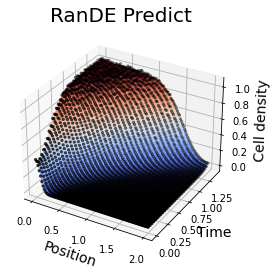

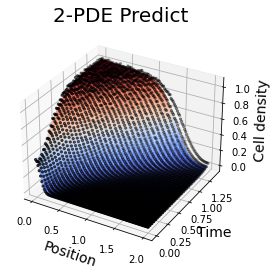

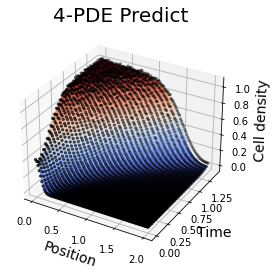

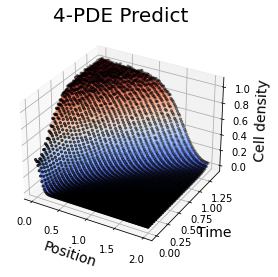

In [9]:
Plot_SurfaceFitting(X, T, u_sim_PMF, U,
                    title='RanDE Predict',
                    save_path='Figures/PMF_Predict_N01_3P_E2.pdf')

Plot_SurfaceFitting(X, T, u_sim_2P, U,
                    title='2-PDE Predict',
                    save_path='Figures/2PDE_Predict_N01_3P_E2.pdf')

Plot_SurfaceFitting(X, T, u_sim_4P, U,
                    title='4-PDE Predict',
                    save_path='Figures/4PDE_Predict_N01_3P_E2.pdf')

Plot_SurfaceFitting(X, T, u_sim_6P, U,
                    title='4-PDE Predict',
                    save_path='Figures/6PDE_Predict_N01_3P_E2.pdf')

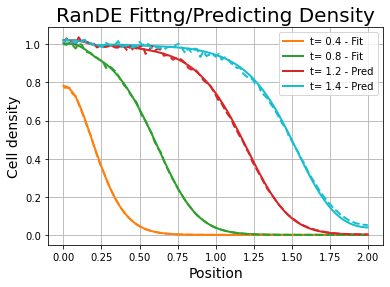

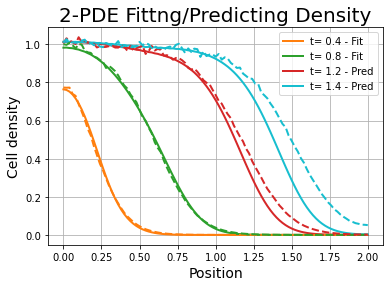

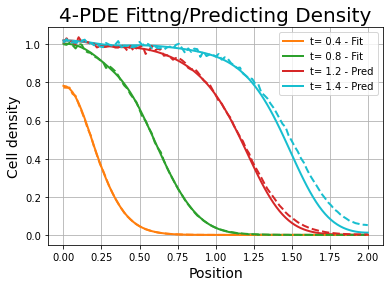

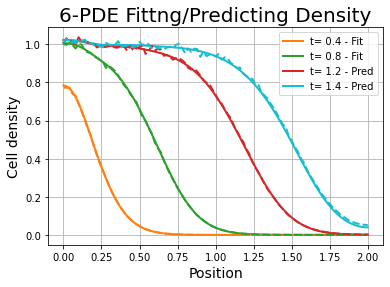

In [10]:
tPlot_idx = [10, 20, 30, -1]
legend_list = ['t= 0.4 - Fit', 't= 0.8 - Fit', 't= 1.2 - Pred', 't= 1.4 - Pred']

Plot_UvsX(X, T, u_sim_PMF, U, 
              t_plot_idcs=tPlot_idx,
              title='RanDE Fittng/Predicting Density',
              legend_list=legend_list,
              save_path='Figures/PMF_Predict_Curves_N01_3P_E2.pdf')
Plot_UvsX(X, T, u_sim_2P, U, 
              t_plot_idcs=tPlot_idx,
              title='2-PDE Fittng/Predicting Density',
              legend_list=legend_list,
              save_path='Figures/2PDE_Predict_Curves_N01_3P_E2.pdf')
Plot_UvsX(X, T, u_sim_4P, U, 
              t_plot_idcs=tPlot_idx,
              title='4-PDE Fittng/Predicting Density',
              legend_list=legend_list,
              save_path='Figures/4PDE_Predict_Curves_N01_3P_E2.pdf')
Plot_UvsX(X, T, u_sim_6P, U, 
              t_plot_idcs=tPlot_idx,
              title='6-PDE Fittng/Predicting Density',
              legend_list=legend_list,
              save_path='Figures/6PDE_Predict_Curves_N01_3P_E2.pdf')

# Compute Prediction Error

In [11]:
PMF_fit_error = sum(sum((u_sim_PMF[:,:26] - U[:,:26])**2))
PDE2_fit_error = sum(sum((u_sim_2P[:,:26] - U[:,:26])**2))
PDE4_fit_error = sum(sum((u_sim_4P[:,:26] - U[:,:26])**2))
PDE6_fit_error = sum(sum((u_sim_6P[:,:26] - U[:,:26])**2))

PMF_pred_error = sum(sum((u_sim_PMF[:,26:] - U[:,26:])**2))
PDE2_pred_error = sum(sum((u_sim_2P[:,26:] - U[:,26:])**2))
PDE4_pred_error = sum(sum((u_sim_4P[:,26:] - U[:,26:])**2))
PDE6_pred_error = sum(sum((u_sim_6P[:,26:] - U[:,26:])**2))

In [12]:
nums_PDEs = [2, 4, 6]
PDE_times = [total_2P_time, total_4P_time, total_6P_time]
PDE_fit_errors  = [PDE2_fit_error, PDE4_fit_error, PDE6_fit_error]
PDE_pred_errors = [PDE2_pred_error, PDE4_pred_error, PDE6_pred_error]

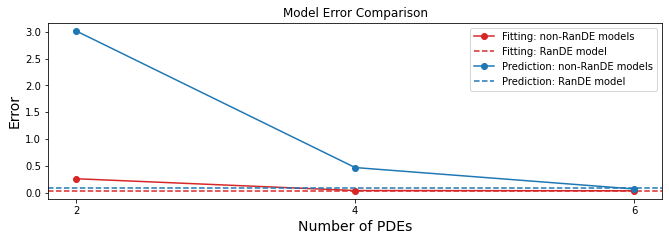

In [13]:
figure_mods = {}
figure_mods['color'] = "tab:red"
figure_mods['marker'] = "o"
figure_mods['ylabel'] = "Error"

# figure_mods['legend_list'] = ['2-PDE', '4-PDE', '6-PDE']

# fig, ax = Plot_ErrorComparison(nums_PDEs=nums_PDEs,
#                                PDE_errors=PDE_fit_errors,
#                                PMF_error=PMF_fit_error,
#                                figure_mods=figure_mods,
#                                title='',
#                                save_path=None)
# figure_mods['color'] = "black"
# figure_mods['marker'] = "^"

fig, ax = Plot_ErrorComparison(nums_PDEs=nums_PDEs,
                               PDE_errors=PDE_fit_errors,
                               PMF_error=PMF_fit_error,
                               figure_mods=figure_mods,
                               title='Model Error Comparison',
                               save_path=None)

ax.plot(nums_PDEs, PDE_pred_errors, color="tab:blue", marker="o")
ax.axhline(y = PMF_pred_error, color = 'tab:blue', linestyle='dashed')
ax.legend(['Fitting: non-RanDE models', 'Fitting: RanDE model', 'Prediction: non-RanDE models', 'Prediction: RanDE model'])
fig.savefig('Figures/Compare_Fit_Pred_Error_3P_E2.pdf',bbox_inches='tight')
# ax2=ax.twinx()
# ax2.plot(nums_PDEs, PDE_pred_errors, color="tab:blue", marker="o")
# ax2.axhline(y = PMF_pred_error, color = 'tab:blue', linestyle='dashed')
# ax2.set_ylabel("Run Time",color="tab:blue",fontsize=14)
# fig.savefig('Figures/Compare_Fit_Pred_Error_2P_E2.pdf',bbox_inches='tight')
# # ax.legend(['Fitting error', '', 'Prediction error', ''],loc='upper center')
# # ax2.legend(['Total run time', ''],loc='upper center')
plt.show()

# Compute Wavespeed

In [14]:
def compute_wavespeed(U, x, t, t_before_idx, t_after_idx, densities):
    
    #
    c_list = []
    
    # Compute delta t
    delta_t = t[t_after_idx] - t[t_before_idx]
    
    # 
    x_interp = np.linspace(min(x), max(x), 1000000)
    
    # Get density arrays
    u_before = U[:, t_before_idx]
    u_after  = U[:, t_after_idx]
    
    # Interpolate u before
    interp = interpolate.interp1d(x,u_before)
    u_before_interp = interp(x_interp)
    
    # Interpolate u after
    interp = interpolate.interp1d(x,u_after)
    u_after_interp = interp(x_interp)
    
    for density in densities:
    
        # Find density idx
        before_idx = np.where(abs(u_before_interp-density) == min(abs(u_before_interp-density)))[0][0]
        after_idx = np.where(abs(u_after_interp-density) == min(abs(u_after_interp-density)))[0][0]

        # Compute wavespeed
        c = (x_interp[after_idx] - x_interp[before_idx])/delta_t
        c_list.append(c)
        
    return c_list

In [15]:
Tbf_idx = 15
Taf_idx = 25

densities = [0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]

data_wave_speed_fit = compute_wavespeed(U, x, t, Tbf_idx, Taf_idx, densities)
PMF_wave_speed_fit  = compute_wavespeed(u_sim_PMF, x, t, Tbf_idx, Taf_idx, densities)
PDE2_wave_speed_fit = compute_wavespeed(u_sim_2P, x, t, Tbf_idx, Taf_idx, densities)
PDE4_wave_speed_fit = compute_wavespeed(u_sim_4P, x, t, Tbf_idx, Taf_idx, densities)
PDE6_wave_speed_fit = compute_wavespeed(u_sim_6P, x, t, Tbf_idx, Taf_idx, densities)

In [16]:
max_fit = max(max(data_wave_speed_fit), 
              max(PMF_wave_speed_fit),
              max(PDE2_wave_speed_fit),
              max(PDE4_wave_speed_fit),
              max(PDE6_wave_speed_fit))

min_fit = min(min(data_wave_speed_fit), 
              min(PMF_wave_speed_fit),
              min(PDE2_wave_speed_fit),
              min(PDE4_wave_speed_fit),
              min(PDE6_wave_speed_fit))
max_fit, min_fit

(1.3171313171313173, 1.2098262098262098)

In [17]:
Tbf_idx = 25
Taf_idx = 35

densities = [0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]

data_wave_speed_pred = compute_wavespeed(U, x, t, Tbf_idx, Taf_idx, densities)
PMF_wave_speed_pred  = compute_wavespeed(u_sim_PMF, x, t, Tbf_idx, Taf_idx, densities)
PDE2_wave_speed_pred = compute_wavespeed(u_sim_2P, x, t, Tbf_idx, Taf_idx, densities)
PDE4_wave_speed_pred = compute_wavespeed(u_sim_4P, x, t, Tbf_idx, Taf_idx, densities)
PDE6_wave_speed_pred = compute_wavespeed(u_sim_6P, x, t, Tbf_idx, Taf_idx, densities)

In [18]:
max_pred = max(max(data_wave_speed_pred), 
              max(PMF_wave_speed_pred),
              max(PDE2_wave_speed_pred),
              max(PDE4_wave_speed_pred),
              max(PDE6_wave_speed_pred))

min_pred = min(min(data_wave_speed_pred), 
              min(PMF_wave_speed_pred),
              min(PDE2_wave_speed_pred),
              min(PDE4_wave_speed_pred),
              min(PDE6_wave_speed_pred))

max_pred, min_pred

(1.6097516097516091, 1.2672962672962669)

(<Figure size 792x792 with 1 Axes>,
 <AxesSubplot:title={'center':'Wave speed in fitting interval'}, xlabel='Density', ylabel='Wave speed'>)

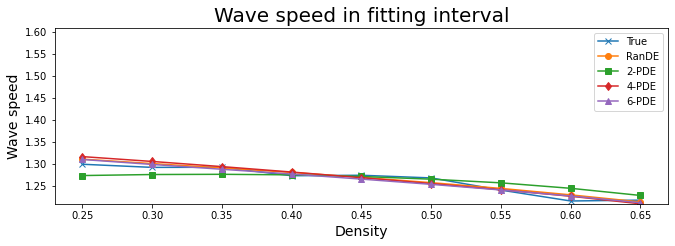

In [19]:
Plot_WaveSpeedComparison(densities,
                         data_wave_speed_fit,
                         PMF_wave_speed_fit,
                         PDE2_wave_speed_fit,
                         PDE4_wave_speed_fit,
                         PDE6_wave_speed_fit,
                         ylim=[min(min_pred, min_fit),max(max_pred, max_fit)],
                         title="Wave speed in fitting interval",
                         save_path='Figures/Wavespeed_Fit_3P_E2.pdf')

(<Figure size 792x792 with 1 Axes>,
 <AxesSubplot:title={'center':'Wave speed in prediction interval'}, xlabel='Density', ylabel='Wave speed'>)

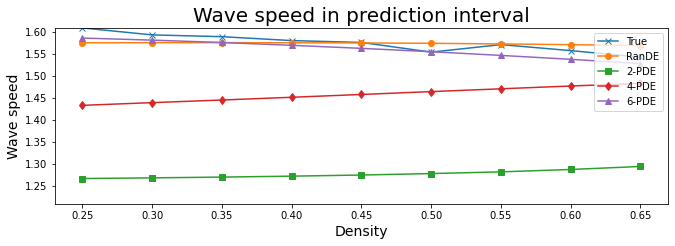

In [20]:
Plot_WaveSpeedComparison(densities,
                         data_wave_speed_pred,
                         PMF_wave_speed_pred,
                         PDE2_wave_speed_pred,
                         PDE4_wave_speed_pred,
                         PDE6_wave_speed_pred,
                         ylim=[min(min_pred, min_fit),max(max_pred, max_fit)],
                         title="Wave speed in prediction interval",
                         save_path='Figures/Wavespeed_Predict_3P_E2.pdf')